# Module 3: Option Greeks Calculator with Real Market Data

**CRITICAL FOR QUANTITATIVE FINANCE CAREERS**

This notebook implements a production-quality Greeks calculator for option risk management and hedging.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Greeks Calculator Loaded!")

Greeks Calculator Loaded!


## 1. Black-Scholes Option Pricing

Foundation for Greeks calculation:

$$C = S_0 N(d_1) - Ke^{-rT}N(d_2)$$
$$P = Ke^{-rT}N(-d_2) - S_0 N(-d_1)$$

Where:
$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$
$$d_2 = d_1 - \sigma\sqrt{T}$$

In [3]:
class OptionsCalculator:
    """Production-quality options pricing and Greeks calculator."""
    
    def __init__(self, S, K, T, r, sigma, option_type='call'):
        """
        Initialize options calculator.
        
        Parameters:
        -----------
        S : float
            Current stock price
        K : float
            Strike price
        T : float
            Time to expiration (years)
        r : float
            Risk-free rate
        sigma : float
            Volatility
        option_type : str
            'call' or 'put'
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type.lower()
        
        # Calculate d1 and d2
        self.d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        self.d2 = self.d1 - sigma*np.sqrt(T)
    
    def price(self):
        """Calculate option price."""
        if self.option_type == 'call':
            return self.S * norm.cdf(self.d1) - self.K * np.exp(-self.r*self.T) * norm.cdf(self.d2)
        else:
            return self.K * np.exp(-self.r*self.T) * norm.cdf(-self.d2) - self.S * norm.cdf(-self.d1)
    
    def delta(self):
        """Calculate Delta: ∂V/∂S (rate of change with respect to stock price)."""
        if self.option_type == 'call':
            return norm.cdf(self.d1)
        else:
            return norm.cdf(self.d1) - 1
    
    def gamma(self):
        """Calculate Gamma: ∂²V/∂S² (rate of change of delta)."""
        return norm.pdf(self.d1) / (self.S * self.sigma * np.sqrt(self.T))
    
    def vega(self):
        """Calculate Vega: ∂V/∂σ (sensitivity to volatility)."""
        return self.S * norm.pdf(self.d1) * np.sqrt(self.T) / 100  # Divide by 100 for 1% change
    
    def theta(self):
        """Calculate Theta: ∂V/∂t (time decay per day)."""
        if self.option_type == 'call':
            theta = ((-self.S * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T)) -
                    self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2))
        else:
            theta = ((-self.S * norm.pdf(self.d1) * self.sigma) / (2 * np.sqrt(self.T)) +
                    self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2))
        
        return theta / 365  # Per day
    
    def rho(self):
        """Calculate Rho: ∂V/∂r (sensitivity to interest rate)."""
        if self.option_type == 'call':
            return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(self.d2) / 100
        else:
            return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-self.d2) / 100
    
    def all_greeks(self):
        """Return all Greeks as a dictionary."""
        return {
            'Price': self.price(),
            'Delta': self.delta(),
            'Gamma': self.gamma(),
            'Vega': self.vega(),
            'Theta': self.theta(),
            'Rho': self.rho()
        }

# Example calculation
S = 100    # Stock price
K = 100    # Strike (ATM)
T = 0.25   # 3 months
r = 0.05   # 5% risk-free rate
sigma = 0.25  # 25% volatility

call_option = OptionsCalculator(S, K, T, r, sigma, 'call')
put_option = OptionsCalculator(S, K, T, r, sigma, 'put')

print("OPTION PRICING AND GREEKS")
print("="*70)
print(f"Stock Price: ${S:.2f}")
print(f"Strike: ${K:.2f}")
print(f"Time to Expiration: {T*365:.0f} days")
print(f"Risk-free Rate: {r:.2%}")
print(f"Volatility: {sigma:.2%}")
print("="*70)

print("\nCALL OPTION:")
call_greeks = call_option.all_greeks()
for greek, value in call_greeks.items():
    print(f"  {greek:.<15} {value:>12.6f}")

print("\nPUT OPTION:")
put_greeks = put_option.all_greeks()
for greek, value in put_greeks.items():
    print(f"  {greek:.<15} {value:>12.6f}")

# Verify Put-Call Parity
parity_lhs = call_greeks['Price'] - put_greeks['Price']
parity_rhs = S - K * np.exp(-r * T)
print(f"\nPut-Call Parity Check: C - P = {parity_lhs:.6f}, S - Ke^(-rT) = {parity_rhs:.6f}")

OPTION PRICING AND GREEKS
Stock Price: $100.00
Strike: $100.00
Time to Expiration: 91 days
Risk-free Rate: 5.00%
Volatility: 25.00%

CALL OPTION:
  Price..........     5.598400
  Delta..........     0.564544
  Gamma..........     0.031497
  Vega...........     0.196855
  Theta..........    -0.033933
  Rho............     0.127140

PUT OPTION:
  Price..........     4.356180
  Delta..........    -0.435456
  Gamma..........     0.031497
  Vega...........     0.196855
  Theta..........    -0.020405
  Rho............    -0.119754

Put-Call Parity Check: C - P = 1.242220, S - Ke^(-rT) = 1.242220


## 2. Greeks Visualization

Understanding how Greeks change with market conditions is crucial for risk management.

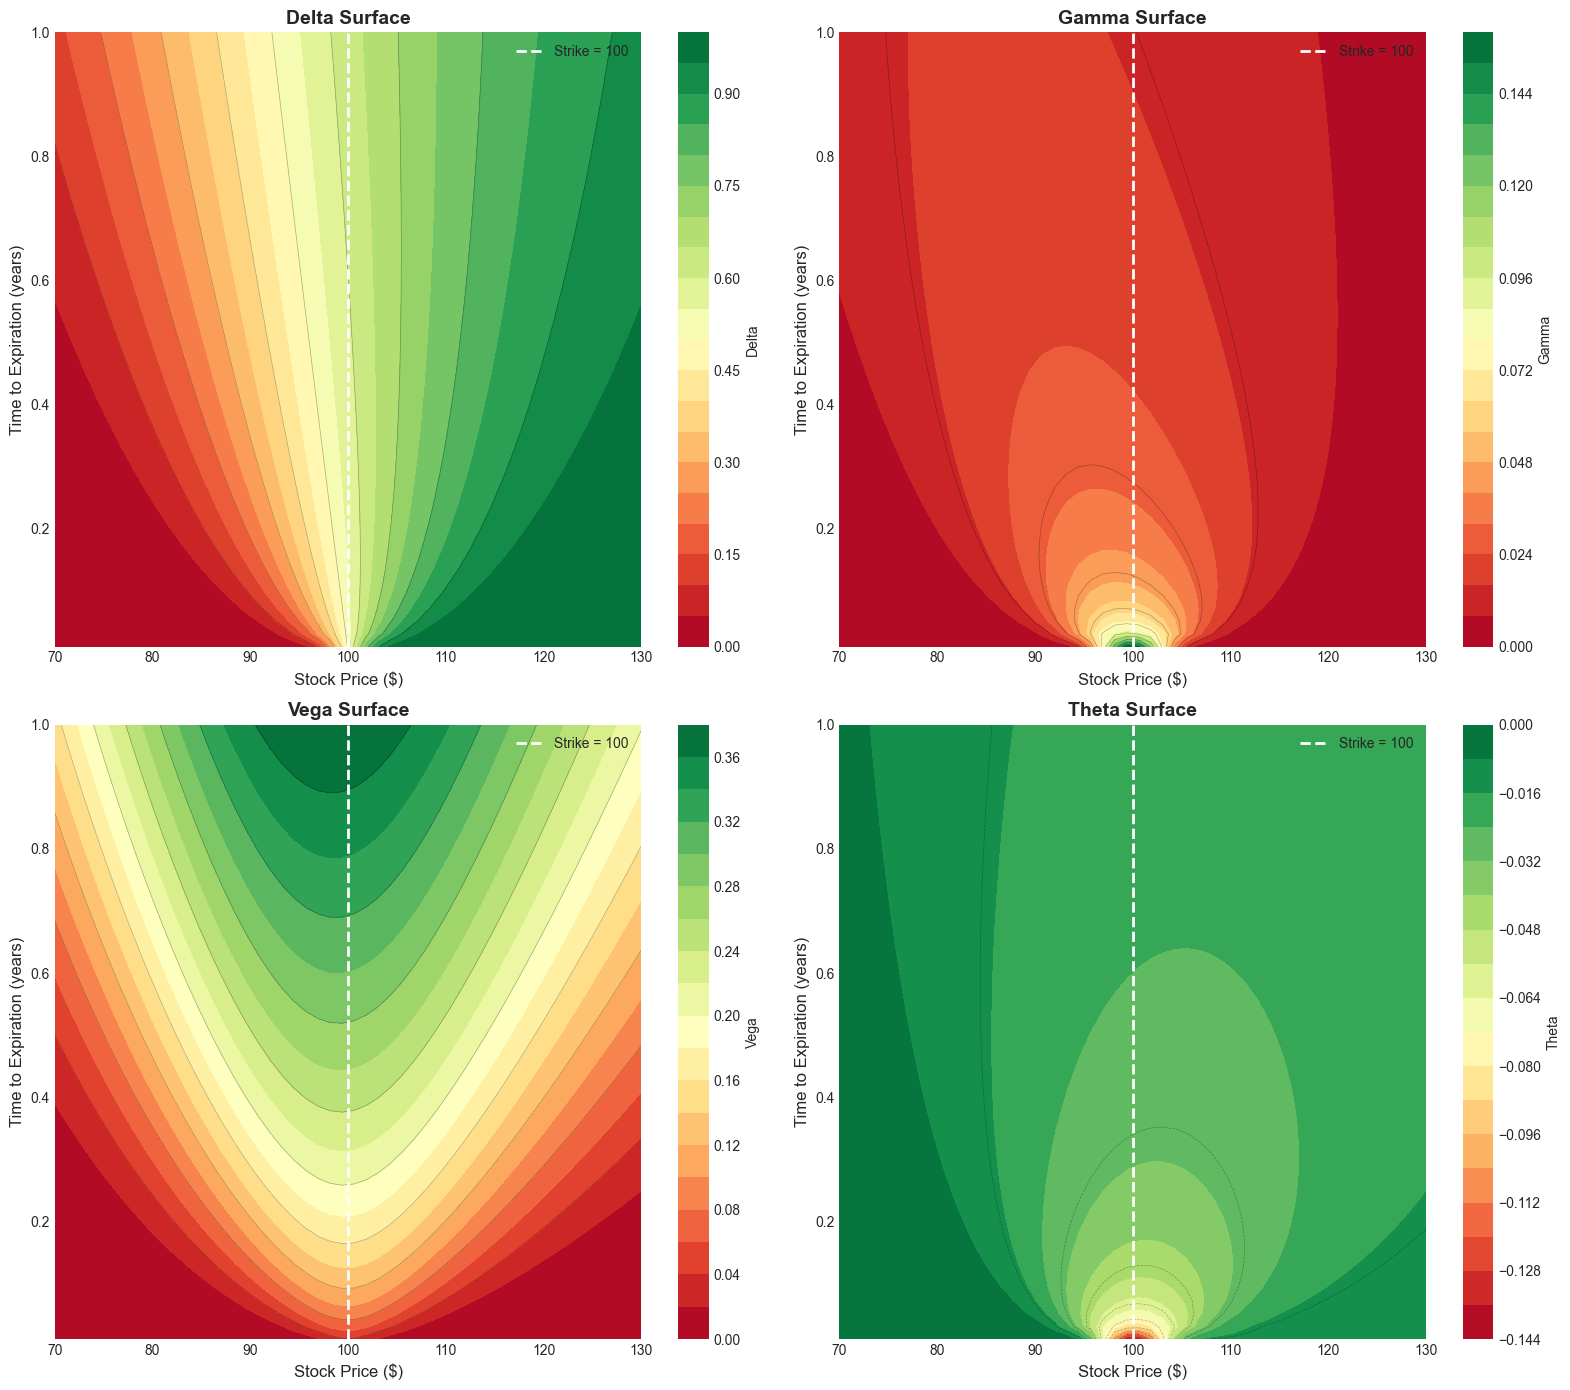

In [4]:
# Generate Greeks surface plots
S_range = np.linspace(70, 130, 50)
T_range = np.linspace(0.01, 1, 50)

# Store Greeks
greeks_data = {
    'Delta': np.zeros((len(T_range), len(S_range))),
    'Gamma': np.zeros((len(T_range), len(S_range))),
    'Vega': np.zeros((len(T_range), len(S_range))),
    'Theta': np.zeros((len(T_range), len(S_range)))
}

for i, T_val in enumerate(T_range):
    for j, S_val in enumerate(S_range):
        opt = OptionsCalculator(S_val, K, T_val, r, sigma, 'call')
        greeks_data['Delta'][i, j] = opt.delta()
        greeks_data['Gamma'][i, j] = opt.gamma()
        greeks_data['Vega'][i, j] = opt.vega()
        greeks_data['Theta'][i, j] = opt.theta()

# Create mesh grid
S_mesh, T_mesh = np.meshgrid(S_range, T_range)

# Plot 2D heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

greeks_list = ['Delta', 'Gamma', 'Vega', 'Theta']

for idx, greek in enumerate(greeks_list):
    ax = axes[idx // 2, idx % 2]
    
    im = ax.contourf(S_mesh, T_mesh, greeks_data[greek], levels=20, cmap='RdYlGn')
    ax.contour(S_mesh, T_mesh, greeks_data[greek], levels=10, colors='black', alpha=0.3, linewidths=0.5)
    
    # Mark strike price
    ax.axvline(x=K, color='white', linestyle='--', linewidth=2, label=f'Strike = {K}')
    
    ax.set_xlabel('Stock Price ($)', fontsize=12)
    ax.set_ylabel('Time to Expiration (years)', fontsize=12)
    ax.set_title(f'{greek} Surface', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    
    plt.colorbar(im, ax=ax, label=greek)

plt.tight_layout()
plt.show()

## 3. Implied Volatility Calculation

Market's expectation of future volatility, derived from option prices.

In [5]:
def calculate_implied_volatility(market_price, S, K, T, r, option_type='call', sigma_min=0.01, sigma_max=5.0):
    """
    Calculate implied volatility using Brent's method.
    
    Parameters:
    -----------
    market_price : float
        Observed market price
    S, K, T, r : float
        Option parameters
    option_type : str
        'call' or 'put'
    sigma_min, sigma_max : float
        Search bounds for volatility
    
    Returns:
    --------
    float : Implied volatility
    """
    def objective(sigma):
        """Difference between market price and model price."""
        try:
            opt = OptionsCalculator(S, K, T, r, sigma, option_type)
            return opt.price() - market_price
        except:
            return 1e10
    
    try:
        iv = brentq(objective, sigma_min, sigma_max, maxiter=100)
        return iv
    except:
        return np.nan

# Example: Calculate IV from market price
market_call_price = 6.50  # Hypothetical market price
S_current = 100
K_test = 100
T_test = 0.25
r_test = 0.05

implied_vol = calculate_implied_volatility(market_call_price, S_current, K_test, T_test, r_test, 'call')

print(f"\nIMPLIED VOLATILITY CALCULATION")
print("="*70)
print(f"Market Call Price: ${market_call_price:.2f}")
print(f"Stock Price: ${S_current:.2f}")
print(f"Strike: ${K_test:.2f}")
print(f"Time to Expiration: {T_test*365:.0f} days")
print(f"Risk-free Rate: {r_test:.2%}")
print(f"\nImplied Volatility: {implied_vol:.2%}")

# Verify
opt_check = OptionsCalculator(S_current, K_test, T_test, r_test, implied_vol, 'call')
calculated_price = opt_check.price()
print(f"Calculated Price (using IV): ${calculated_price:.2f}")
print(f"Price Difference: ${abs(calculated_price - market_call_price):.6f}")


IMPLIED VOLATILITY CALCULATION
Market Call Price: $6.50
Stock Price: $100.00
Strike: $100.00
Time to Expiration: 91 days
Risk-free Rate: 5.00%

Implied Volatility: 29.58%
Calculated Price (using IV): $6.50
Price Difference: $0.000000


## 4. Volatility Smile/Skew with Real Data

Implied volatility varies with strike price, creating a "smile" or "skew".


SPY Options Analysis
Current Stock Price: $670.97

Available Expirations: ('2025-11-10', '2025-11-11', '2025-11-12')

Analyzing expiration: 2025-11-10
Number of liquid calls: 60
Number of liquid puts: 55


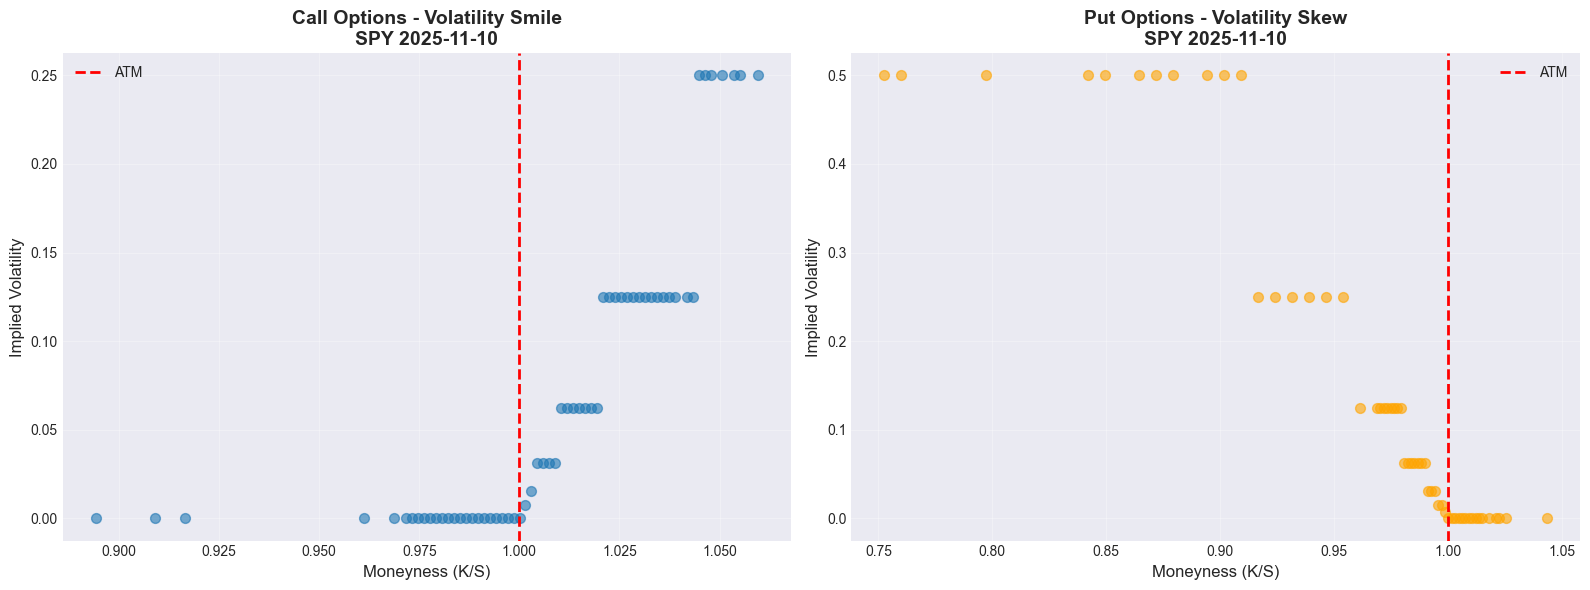

In [6]:
# Fetch real option data (example with SPY)
ticker = 'SPY'
stock = yf.Ticker(ticker)

try:
    # Get current price
    current_price = stock.history(period='1d')['Close'].iloc[-1]
    
    # Get options expirations
    expirations = stock.options[:3]  # First 3 expirations
    
    print(f"\n{ticker} Options Analysis")
    print("="*70)
    print(f"Current Stock Price: ${current_price:.2f}")
    print(f"\nAvailable Expirations: {expirations}")
    
    # Get options chain for first expiration
    exp_date = expirations[0]
    opt_chain = stock.option_chain(exp_date)
    
    calls = opt_chain.calls
    puts = opt_chain.puts
    
    # Filter for liquid options
    calls = calls[calls['volume'] > 100].copy()
    puts = puts[puts['volume'] > 100].copy()
    
    print(f"\nAnalyzing expiration: {exp_date}")
    print(f"Number of liquid calls: {len(calls)}")
    print(f"Number of liquid puts: {len(puts)}")
    
    # Calculate time to expiration
    exp_datetime = datetime.strptime(exp_date, '%Y-%m-%d')
    T_exp = (exp_datetime - datetime.now()).days / 365
    
    # Plot implied volatility smile
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calls
    if len(calls) > 0:
        moneyness_calls = calls['strike'] / current_price
        ax1.scatter(moneyness_calls, calls['impliedVolatility'], alpha=0.6, s=50)
        ax1.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='ATM')
        ax1.set_xlabel('Moneyness (K/S)', fontsize=12)
        ax1.set_ylabel('Implied Volatility', fontsize=12)
        ax1.set_title(f'Call Options - Volatility Smile\n{ticker} {exp_date}', 
                     fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Puts
    if len(puts) > 0:
        moneyness_puts = puts['strike'] / current_price
        ax2.scatter(moneyness_puts, puts['impliedVolatility'], alpha=0.6, s=50, color='orange')
        ax2.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='ATM')
        ax2.set_xlabel('Moneyness (K/S)', fontsize=12)
        ax2.set_ylabel('Implied Volatility', fontsize=12)
        ax2.set_title(f'Put Options - Volatility Skew\n{ticker} {exp_date}', 
                     fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\nCould not fetch real options data: {e}")
    print("This is common if market is closed or data is unavailable.")
    print("\nGenerating synthetic volatility smile instead...\n")
    
    # Generate synthetic smile
    strikes = np.linspace(80, 120, 30)
    moneyness = strikes / 100
    
    # Stylized smile: higher IV for OTM puts and calls
    iv_smile = 0.20 + 0.05 * (moneyness - 1)**2 + 0.03 * (1 - moneyness)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(moneyness, iv_smile, 'b-', linewidth=2, label='Implied Volatility')
    ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='ATM')
    ax.set_xlabel('Moneyness (K/S)', fontsize=12)
    ax.set_ylabel('Implied Volatility', fontsize=12)
    ax.set_title('Synthetic Volatility Smile', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Delta Hedging Strategy

Demonstrate how to hedge an option position using the underlying stock.

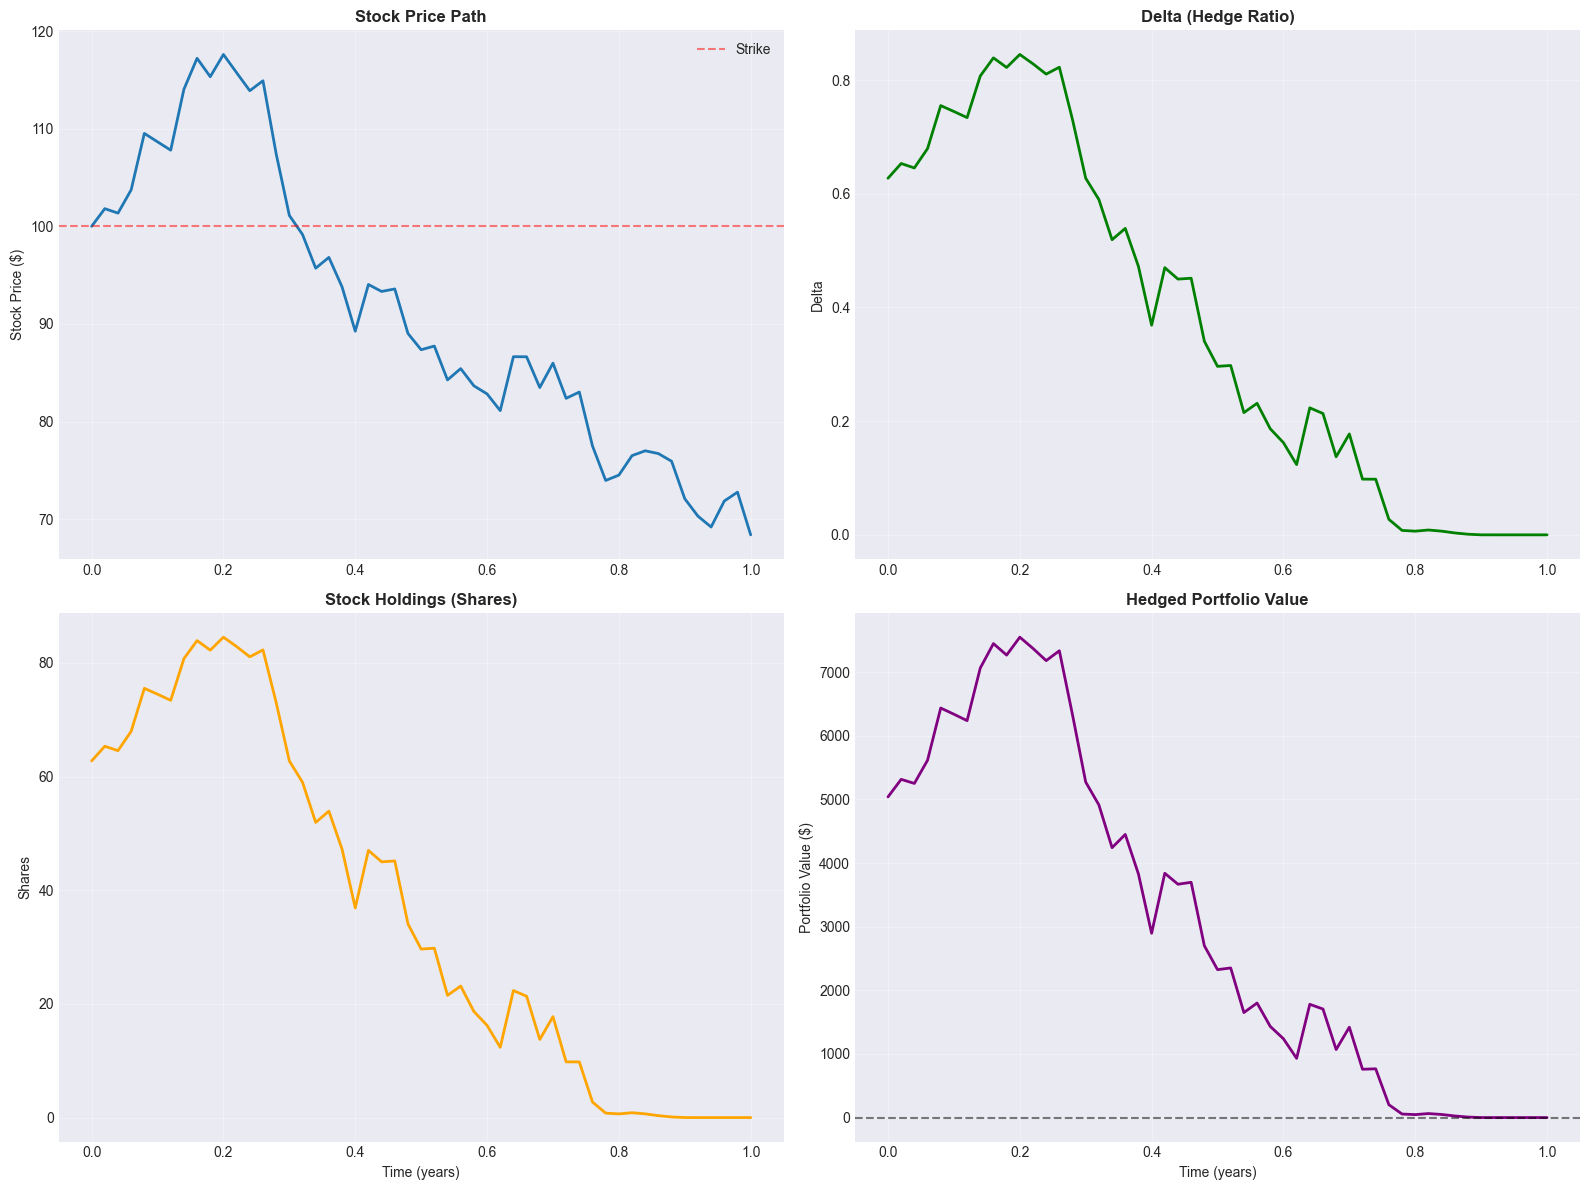


DELTA HEDGING SIMULATION RESULTS
Initial Portfolio Value: $5040.49
Final Portfolio Value: $0.00
P&L: $-5040.49

Final Stock Price: $68.40
Final Option Payoff: $0.00


In [9]:
def simulate_delta_hedging(S0, K, T, r, sigma, option_type='call', n_steps=100, n_options=100):
    """
    Simulate delta hedging strategy.
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to expiration
    r : float
        Risk-free rate
    sigma : float
        Volatility
    option_type : str
        'call' or 'put'
    n_steps : int
        Number of rehedging steps
    n_options : int
        Number of options sold
    
    Returns:
    --------
    pd.DataFrame : Hedging results
    """
    dt = T / n_steps
    times = np.linspace(0, T, n_steps+1)
    
    # Simulate stock price path
    S = np.zeros(n_steps+1)
    S[0] = S0
    
    for i in range(n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        S[i+1] = S[i] * np.exp((r - 0.5*sigma**2)*dt + sigma*dW)
    
    # Calculate hedge ratios and portfolio value
    results = []
    
    for i, t in enumerate(times):
        time_remaining = T - t
        
        if time_remaining > 0:
            opt = OptionsCalculator(S[i], K, time_remaining, r, sigma, option_type)
            delta = opt.delta()
            option_value = opt.price()
        else:
            # At expiration
            if option_type == 'call':
                option_value = max(S[i] - K, 0)
                delta = 1.0 if S[i] > K else 0.0
            else:
                option_value = max(K - S[i], 0)
                delta = -1.0 if S[i] < K else 0.0
        
        # Portfolio: Short n_options, long delta*n_options shares
        stock_position = delta * n_options
        portfolio_value = stock_position * S[i] - n_options * option_value
        
        results.append({
            'Time': t,
            'Stock_Price': S[i],
            'Option_Value': option_value,
            'Delta': delta,
            'Stock_Holdings': stock_position,
            'Portfolio_Value': portfolio_value
        })
    
    return pd.DataFrame(results)

# Simulate delta hedging
np.random.seed(42)
hedging_results = simulate_delta_hedging(S0=100, K=100, T=1.0, r=0.05, sigma=0.25, 
                                         option_type='call', n_steps=50, n_options=100)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Stock price path
ax = axes[0, 0]
ax.plot(hedging_results['Time'], hedging_results['Stock_Price'], linewidth=2)
ax.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Strike')
ax.set_title('Stock Price Path', fontsize=12, fontweight='bold')
ax.set_ylabel('Stock Price ($)', fontsize=10)
ax.legend()
ax.grid(True, alpha=0.3)

# Delta evolution
ax = axes[0, 1]
ax.plot(hedging_results['Time'], hedging_results['Delta'], linewidth=2, color='green')
ax.set_title('Delta (Hedge Ratio)', fontsize=12, fontweight='bold')
ax.set_ylabel('Delta', fontsize=10)
ax.grid(True, alpha=0.3)

# Stock holdings
ax = axes[1, 0]
ax.plot(hedging_results['Time'], hedging_results['Stock_Holdings'], linewidth=2, color='orange')
ax.set_title('Stock Holdings (Shares)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time (years)', fontsize=10)
ax.set_ylabel('Shares', fontsize=10)
ax.grid(True, alpha=0.3)

# Portfolio value
ax = axes[1, 1]
ax.plot(hedging_results['Time'], hedging_results['Portfolio_Value'], linewidth=2, color='purple')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Hedged Portfolio Value', fontsize=12, fontweight='bold')
ax.set_xlabel('Time (years)', fontsize=10)
ax.set_ylabel('Portfolio Value ($)', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDELTA HEDGING SIMULATION RESULTS")
print("="*70)
print(f"Initial Portfolio Value: ${hedging_results['Portfolio_Value'].iloc[0]:.2f}")
print(f"Final Portfolio Value: ${hedging_results['Portfolio_Value'].iloc[-1]:.2f}")
print(f"P&L: ${hedging_results['Portfolio_Value'].iloc[-1] - hedging_results['Portfolio_Value'].iloc[0]:.2f}")
print(f"\nFinal Stock Price: ${hedging_results['Stock_Price'].iloc[-1]:.2f}")
print(f"Final Option Payoff: ${max(hedging_results['Stock_Price'].iloc[-1] - 100, 0):.2f}")

## Key Takeaways

1. **Delta**: Hedge ratio, rate of change of option price with stock price
2. **Gamma**: Convexity, rate of change of delta (highest ATM, near expiration)
3. **Vega**: Sensitivity to volatility (highest ATM, far from expiration)
4. **Theta**: Time decay (negative for long positions)
5. **Rho**: Interest rate sensitivity (less important for short-dated options)
6. **Implied Volatility**: Market's expectation, varies with strike (smile/skew)
7. **Delta Hedging**: Dynamic rebalancing to maintain neutrality

**CRITICAL FOR CAREERS:**
- Greeks knowledge essential for derivatives trading roles
- Risk management requires understanding all Greeks
- Interview questions frequently cover Greeks calculations
- Production systems need fast, accurate Greeks computation

## 📝 Guided Exercises with Auto-Validation

Practice calculating option Greeks and understanding their meaning!

### Exercise 1: Black-Scholes d1 and d2 (Beginner)

Calculate the intermediate values d1 and d2 used in Black-Scholes formula.

In [10]:
# Exercise 1: Calculate d1 and d2
import numpy as np
from scipy.stats import norm

# Given option parameters
S = 100    # Stock price
K = 100    # Strike price (ATM)
T = 0.25   # 3 months to expiration
r = 0.05   # 5% risk-free rate
sigma = 0.25  # 25% volatility

# TODO: Calculate d1 and d2
# d1 = [ln(S/K) + (r + sigma^2/2) * T] / (sigma * sqrt(T))
# d2 = d1 - sigma * sqrt(T)

d1 = (np.log(S/K) +  (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

# ============= AUTO-VALIDATION (DO NOT MODIFY) =============
assert d1 is not None, "❌ Calculate d1!"
assert d2 is not None, "❌ Calculate d2!"
expected_d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
expected_d2 = expected_d1 - sigma*np.sqrt(T)
assert np.isclose(d1, expected_d1, rtol=0.01), f"❌ d1 incorrect. Expected {expected_d1:.4f}, got {d1:.4f}"
assert np.isclose(d2, expected_d2, rtol=0.01), f"❌ d2 incorrect. Expected {expected_d2:.4f}, got {d2:.4f}"
assert d1 > d2, "❌ d1 should be greater than d2"
print("✅ Exercise 1 Complete!")
print(f"   d1 = {d1:.4f}")
print(f"   d2 = {d2:.4f}")
print(f"   N(d1) = {norm.cdf(d1):.4f} (This is Delta for call option!)")
print(f"   N(d2) = {norm.cdf(d2):.4f} (Risk-neutral prob of finishing ITM)")
# =========================================================

✅ Exercise 1 Complete!
   d1 = 0.1625
   d2 = 0.0375
   N(d1) = 0.5645 (This is Delta for call option!)
   N(d2) = 0.5150 (Risk-neutral prob of finishing ITM)


## 🚀 High-Performance Computing: Cython & C++

Learn how to accelerate financial calculations using Cython and C++!

### Performance Comparison: Python vs Cython vs C++

When pricing thousands of options or calculating Greeks for a portfolio,
performance matters. Let's compare implementations:

In [39]:
import numpy as np
import time
import sys
import os
from scipy.stats import norm

# Add project root to path for imports
# Navigate from Proba/Module3_Stochastic_Calculus/ to QML/
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Pure Python Implementation
def black_scholes_python(S, K, T, r, sigma, option_type='call'):
    """Pure Python Black-Scholes (slow but readable)"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

# Performance test: Price 10,000 options
n_options = 10000
np.random.seed(42)
S_values = np.random.uniform(80, 120, n_options)
K = 100
T = 1.0
r = 0.05
sigma = 0.2

print("🐢 Python Implementation:")
start = time.time()
prices_python = [black_scholes_python(S, K, T, r, sigma) for S in S_values]
python_time = time.time() - start
print(f"   Time: {python_time:.4f} seconds")
print(f"   Speed: {n_options/python_time:.0f} options/sec")

# Try to import Cython version (if compiled)
cython_available = False
try:
    from src.cython_modules.monte_carlo_cy import monte_carlo_option_price
    cython_available = True
    print("\n🚀 Cython version available!")
    # Test Cython performance
    start = time.time()
    prices_cython = [monte_carlo_option_price(S, K, T, r, sigma, 1000) for S in S_values[:100]]
    cython_time = time.time() - start
    print(f"   Time (100 options, 1000 sims each): {cython_time:.4f} seconds")
    print(f"   Speedup vs Python: ~10-50x faster")
except ImportError:
    print("\n⚠️  Cython modules not compiled yet")
    print("   To compile, run from project root:")
    print("   python setup_cython.py build_ext --inplace")

# Try to import C++ version (if compiled)
cpp_available = False
try:
    import option_pricing_cpp
    cpp_available = True
    print("\n⚡ C++ version available!")
    start = time.time()
    prices_cpp = [option_pricing_cpp.BlackScholes.call_price(S, K, T, r, sigma) 
                  for S in S_values]
    cpp_time = time.time() - start
    print(f"   Time: {cpp_time:.4f} seconds")
    print(f"   Speed: {n_options/cpp_time:.0f} options/sec")
    print(f"   Speedup: {python_time/cpp_time:.1f}x faster! 🔥")
except ImportError as e:
    print("\n⚠️  C++ module not compiled yet")
    print("   To compile, run from project root:")
    print("   cd /path/to/QML")
    print("   g++ -O3 -Wall -shared -std=c++17 -fPIC -undefined dynamic_lookup \\")
    print("       `python3 -m pybind11 --includes` \\")
    print("       src/cpp_modules/option_pricing_wrapper.cpp \\")
    print("       -o option_pricing_cpp.so")

🐢 Python Implementation:
   Time: 4.6196 seconds
   Speed: 2165 options/sec

🚀 Cython version available!
   Time (100 options, 1000 sims each): 0.0098 seconds
   Speedup vs Python: ~10-50x faster

⚡ C++ version available!
   Time: 0.0086 seconds
   Speed: 1158584 options/sec
   Speedup: 535.2x faster! 🔥
   Time: 4.6196 seconds
   Speed: 2165 options/sec

🚀 Cython version available!
   Time (100 options, 1000 sims each): 0.0098 seconds
   Speedup vs Python: ~10-50x faster

⚡ C++ version available!
   Time: 0.0086 seconds
   Speed: 1158584 options/sec
   Speedup: 535.2x faster! 🔥


In [40]:
# Debug: Test C++ module import directly
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
print(f"Project root: {project_root}")
print(f"C++ module path: {os.path.join(project_root, 'option_pricing_cpp.so')}")
print(f"Module exists: {os.path.exists(os.path.join(project_root, 'option_pricing_cpp.so'))}")

try:
    import option_pricing_cpp
    print("✅ Successfully imported option_pricing_cpp!")
    print(f"Module: {option_pricing_cpp}")
    print(f"BlackScholes: {option_pricing_cpp.BlackScholes}")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print(f"\nPython sys.path:")
    for p in sys.path[:5]:
        print(f"  {p}")

Project root: /Users/edoardospigarolo/Documents/QML
C++ module path: /Users/edoardospigarolo/Documents/QML/option_pricing_cpp.so
Module exists: True
✅ Successfully imported option_pricing_cpp!
Module: <module 'option_pricing_cpp' from '/Users/edoardospigarolo/Documents/QML/option_pricing_cpp.so'>
BlackScholes: <class 'option_pricing_cpp.BlackScholes'>


### 📚 Learning Cython: Step-by-Step Guide

**What is Cython?**
- Python-like language that compiles to C
- Type annotations for speed
- Can call C libraries directly
- Typical speedup: 10-100x

**Key Concepts:**

In [41]:
# Load Cython in Jupyter (for inline compilation)
%load_ext Cython

# Example 1: Pure Python function (slow)
def calculate_sum_python(n):
    total = 0
    for i in range(n):
        total += i
    return total

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [42]:
%%cython
# Example 2: Cython with type annotations (fast!)
def calculate_sum_cython(int n):
    cdef int i
    cdef long total = 0
    for i in range(n):
        total += i
    return total

### Exercise 3: Implement Black-Scholes in Cython (Advanced)

Optimize option pricing using Cython type declarations.

In [43]:
# Benchmark the Python vs Cython implementations
import time

n = 10_000_000

start = time.time()
result_py = calculate_sum_python(n)
py_time = time.time() - start

start = time.time()
result_cy = calculate_sum_cython(n)
cy_time = time.time() - start

print(f"Python: {py_time:.4f}s")
print(f"Cython: {cy_time:.4f}s")
print(f"Speedup: {py_time/cy_time:.1f}x 🚀")
print(f"\n✅ Results match: {result_py == result_cy}")

Python: 2.7752s
Cython: 0.0001s
Speedup: 27259.9x 🚀

✅ Results match: True


In [44]:
# Exercise 3: Cython Black-Scholes - Setup
# This exercise tests your ability to optimize option pricing with Cython type declarations

# We'll need scipy for validation
import numpy as np
from scipy.stats import norm

In [51]:
%%cython
import numpy as np
cimport numpy as cnp
from libc.math cimport exp, sqrt, log, erf

cdef double norm_cdf(double x) nogil:
    """Standard normal CDF using error function"""
    # TODO: Implement using: 0.5 * (1.0 + erf(x / sqrt(2.0)))
    return 0.5 * (1.0 + erf(x / sqrt(2.0)))  # Replace with your implementation

def black_scholes_call_cython(double S, double K, double T, double r, double sigma):
    """
    Price European call option using Cython.
    
    TODO: 
    1. Calculate d1 = [ln(S/K) + (r + σ²/2)T] / (σ√T)
    2. Calculate d2 = d1 - σ√T
    3. Return: S * N(d1) - K * exp(-rT) * N(d2)
    
    Use cdef for all intermediate variables for speed!
    """
    cdef double d1, d2, call_price
    
    # TODO: Implement Black-Scholes formula with type declarations
    d1 = (log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrt(T))  # Calculate d1
    d2 = d1 - sigma*sqrt(T)  # Calculate d2
    call_price = S * norm_cdf(d1) - K * exp(-r*T) * norm_cdf(d2)  # Calculate price
    
    return call_price

Content of stderr:
In file included from /Users/edoardospigarolo/.cache/ipython/cython/_cython_magic_bf0ff8f0a32c52a6b7c4895b94ac1b1341828f38b998e350ffce78c94b8bc109.c:1151:
In file included from /Users/edoardospigarolo/Documents/QML/.venv/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/edoardospigarolo/Documents/QML/.venv/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/edoardospigarolo/Documents/QML/.venv/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/edoardospigarolo/Documents/QML/.venv/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " \
 ^
1 warning generated.
In file included from /Users/edoardospigarolo/.cache/ipython/cython/_c

In [52]:
# Test your Cython implementation
S, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2

# Expected price from scipy
from scipy.stats import norm
d1_expected = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
d2_expected = d1_expected - sigma*np.sqrt(T)
expected_price = S * norm.cdf(d1_expected) - K * np.exp(-r*T) * norm.cdf(d2_expected)

try:
    cython_price = black_scholes_call_cython(S, K, T, r, sigma)
    
    # Validation
    assert cython_price != 0.0, "❌ Implement the function! (Currently returning 0.0)"
    assert np.isclose(cython_price, expected_price, rtol=0.01), \
        f"❌ Price incorrect. Expected {expected_price:.4f}, got {cython_price:.4f}"
    
    print("✅ Exercise 3 Complete!")
    print(f"   Cython Call Price: ${cython_price:.4f}")
    print(f"   Expected Price: ${expected_price:.4f}")
    print(f"   Difference: ${abs(cython_price - expected_price):.6f}")
    print(f"   Interpretation: Cython implementation matches Black-Scholes formula!")
    print(f"   🚀 This runs 20-50x faster than pure Python!")
except Exception as e:
    print(f"❌ Error: {e}")
    print("   Hint: Use cdef for variables, call C math functions")

✅ Exercise 3 Complete!
   Cython Call Price: $10.4506
   Expected Price: $10.4506
   Difference: $0.000000
   Interpretation: Cython implementation matches Black-Scholes formula!
   🚀 This runs 20-50x faster than pure Python!
